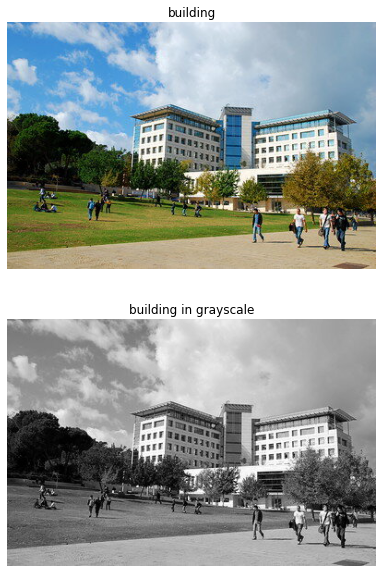

<Figure size 576x360 with 0 Axes>

In [5]:
#!/usr/bin/env python
# coding: utf-8
#Imports we need to use.
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
 
# QUESTION 1:
# part 1.a creating the input an image of a building
# Take a picture for Technion building.
# display the Original image, and its gray scale, using unit8.
# Take a selfie image 315X315.
building_image = cv2.imread(os.path.join(".","../my_data","building.jpg"))

# convert the image to gray scale mode.
building_image_rgb = cv2.cvtColor(building_image, cv2.COLOR_BGR2RGB)
building_grayscale = cv2.cvtColor(building_image,cv2.COLOR_BGR2GRAY)
# make sure uint8.
building_image.shape,building_image.dtype
building_grayscale.shape , building_grayscale.dtype

# display images
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(2, 1 ,1) # create a subplot of certain size
ax.imshow(building_image_rgb)
ax.set_title("building")
ax.set_axis_off()

fig2 = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(2, 1 ,2) # create a subplot of certain size
ax.imshow(building_grayscale, cmap='gray')
ax.set_title("building in grayscale")
ax.set_axis_off()



Text(0, 0.5, 'v')

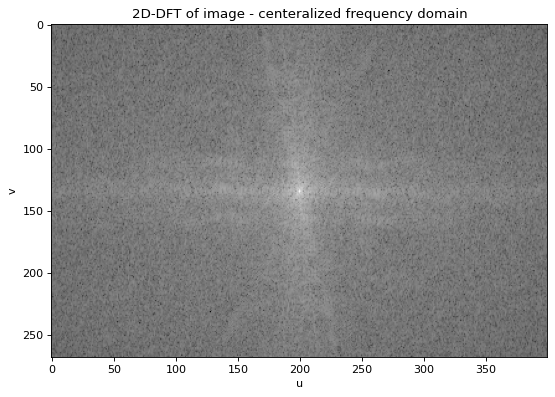

In [6]:
# part 1.b 2D-DFT.
ft = np.fft.fft2(building_grayscale)
ftshift = np.fft.fftshift(ft)
plt.figure(figsize=(8,6),dpi=80)
plt.imshow(np.log(1+np.abs(ftshift)), cmap='gray')
plt.title('2D-DFT of image - centeralized frequency domain')
plt.xlabel('u')
plt.ylabel('v')

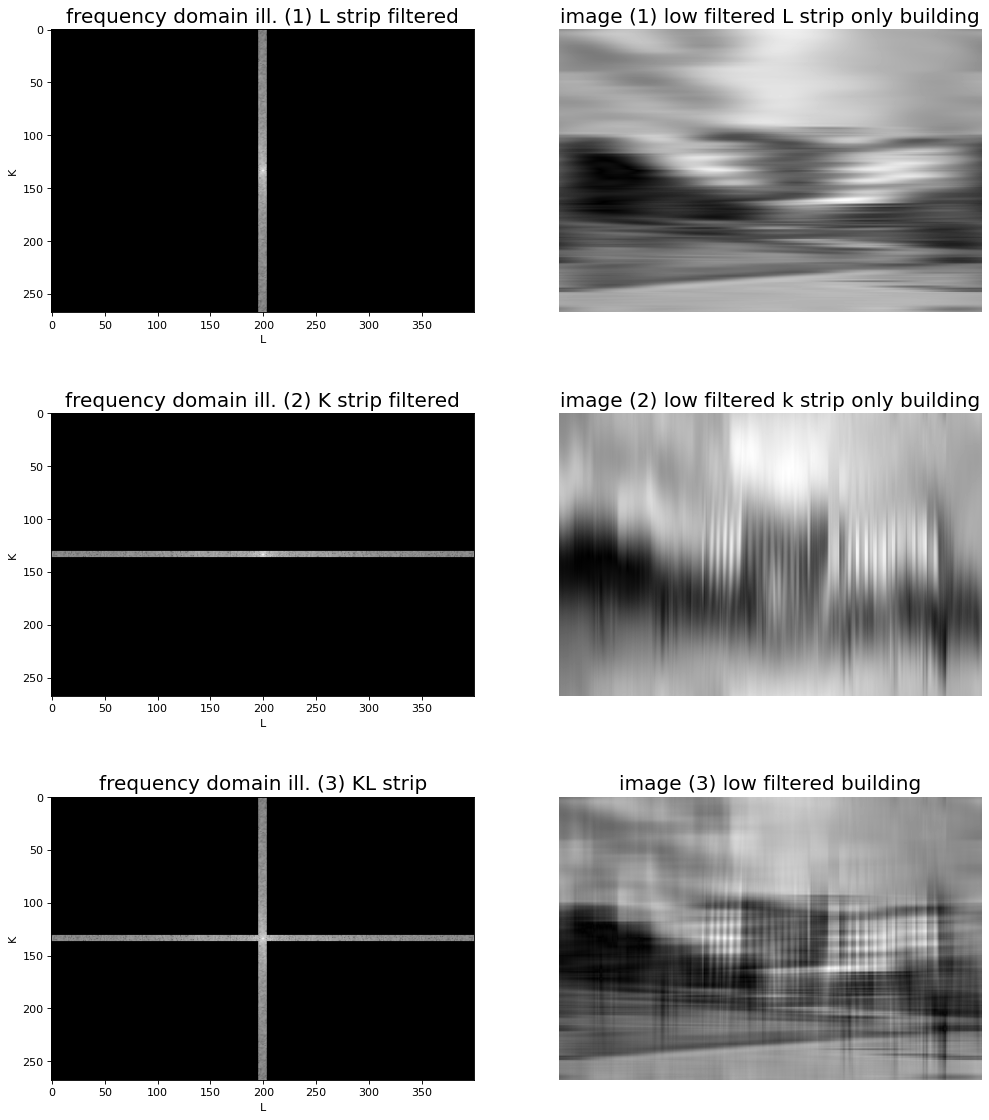

In [7]:
# part 1.c 2% low pass frequency filtering 

# defining the dimensions for abstraction purposes
# K is no. rows , L is no. columns
[K,L] = building_grayscale.shape 
two_percnt_freq_L = L*2/100
two_percnt_freq_K = K  *2 / 100
half_two_percnt_freq_L = round(two_percnt_freq_L / 2)
half_two_percnt_freq_K = round(two_percnt_freq_K / 2)
center_freq_L = round((L - 1) / 2) 
center_freq_K = round((K - 1) / 2) 

L_strip_right = center_freq_L - half_two_percnt_freq_L
L_strip_left = center_freq_L  + half_two_percnt_freq_L

K_strip_up = center_freq_K - half_two_percnt_freq_K
K_strip_down = center_freq_K  + half_two_percnt_freq_K

# L strip in the K direction: zeroing unwanted values
ft_original = ftshift # Fourier transform for the grayscaled picture.
ft_Lstrip = np.zeros(ft_original.shape,dtype='complex128')
# adding L strip
ft_Lstrip[:,L_strip_right:L_strip_left] = ft_original[:,L_strip_right:L_strip_left] 

# display
fig = plt.figure(figsize=(15,18),dpi=80)
ax = fig.add_subplot(3, 2 ,1) # create a subplot of certain size
ax.imshow(np.log(1+np.abs(ft_Lstrip)), cmap='gray')
ax.set_title("frequency domain ill. (1) L strip filtered",fontsize=18)
ax.set_xlabel("L")
ax.set_ylabel("K")

# K strip in L direction: zeroing unwanted values 
ft_Kstrip = np.zeros(ft_original.shape, dtype='complex128')
# adding K strip
ft_Kstrip[K_strip_up:K_strip_down,:] = ft_original[K_strip_up:K_strip_down,:]

# display
ax = fig.add_subplot(3, 2 ,3)
ax.imshow(np.log(1+np.abs(ft_Kstrip)), cmap='gray')
ax.set_title("frequency domain ill. (2) K strip filtered",fontsize=18) 
ax.set_xlabel("L")
ax.set_ylabel("K")

# merge between two matrices, ft_Lstrip,ft_Kstrip, into one matrix, ft_KL.
ft_KL = np.zeros(ft_original.shape,dtype='complex128')
ft_intersection = np.zeros(ft_original.shape,dtype='complex128')
ft_intersection[K_strip_up:K_strip_down,L_strip_right:L_strip_left] = ft_original[K_strip_up:K_strip_down,L_strip_right:L_strip_left]
ft_KL = ft_Lstrip + ft_Kstrip - ft_intersection

# display
ax = fig.add_subplot(3, 2 ,5)
ax.imshow(np.log(1+np.abs(ft_KL)), cmap='gray')
ax.set_title("frequency domain ill. (3) KL strip",fontsize=18)
ax.set_xlabel("L")
ax.set_ylabel("K")

# presenting the building images after LPF.
# Lstrip only
ft_Lstrip_new = np.fft.ifftshift(ft_Lstrip)
L_image = np.fft.ifft2(ft_Lstrip_new)

ax = fig.add_subplot(3, 2 ,2) # create a subplot of certain size
ax.imshow(abs(L_image),cmap='gray')
ax.set_title("image (1) low filtered L strip only building",fontsize=18)
ax.set_axis_off()

# Kstrip only
ft_Kstrip_new = np.fft.ifftshift(ft_Kstrip)
k_image = np.fft.ifft2(ft_Kstrip_new)

ax = fig.add_subplot(3, 2 ,4) # create a subplot of certain size
ax.imshow(abs(k_image),cmap='gray')
ax.set_title("image (2) low filtered k strip only building",fontsize=18)
ax.set_axis_off()

# both K and L strips 
ft_KL = np.fft.ifftshift(ft_KL)
filtered_image = np.fft.ifft2(ft_KL)

ax = fig.add_subplot(3, 2 ,6) # create a subplot of certain size
ax.imshow(abs(filtered_image),cmap='gray')
ax.set_title("image (3) low filtered building",fontsize=18)
ax.set_axis_off()


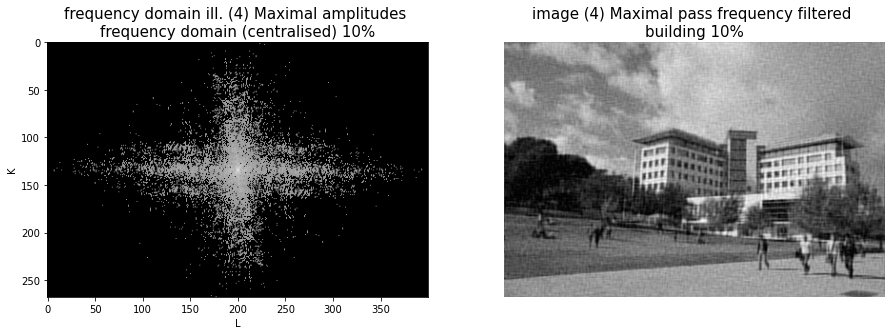

In [8]:
# part 1.d Max pass frequency filtering

def max_freq_filtering(fshift, percentage):
#     """
#      Reconstruct an image using only its maximal amplitude frequencies.
#      :param fshift: The fft of an image, **after fftshift** -
#      complex float ndarray of size [H x W].
#      :param percentage: the wanted precentege of maximal frequencies.
#      :return:
#      fMaxFreq: The filtered frequency domain result -
#      complex float ndarray of size [H x W].
#      imgMaxFreq: The filtered image - real float ndarray of size [H x W].
#     """

    ft_shift_tp = np.fft.ifftshift(fshift)
    [row , column] = ft_shift_tp.shape

    number_ofmax_freq = round(column*row*percentage/100)
    ft_temp =  np.zeros(column*row,dtype = 'int')#saving the amplitude of all the freqs.


    index_temp = 0 # the indices of ft_temp. 

    for r in range(row):
        for col in range(column):
            ft_temp[index_temp] = abs(ft_shift_tp[r,col])
            index_temp+=1 

    ft_temp = np.sort(ft_temp)
    ft_temp = ft_temp[column*row-number_ofmax_freq:]
    
    ft_shift_tp[abs(ft_shift_tp)<min(ft_temp)]=0
    
    #decenteralised filtered frequency domain  
    fMaxFreq = ft_shift_tp 

    # inverse fft and reconstruct image based on the newly filtered domain
    imgMaxFreq = np.fft.ifft2(ft_shift_tp)
     
    
    return fMaxFreq, imgMaxFreq

##main##

percentage = 10  # <-----------------------------------------change percentage here!
fMaxFreq, imgMaxFreq = max_freq_filtering(ftshift,percentage)
    
# display the filtered frequency domain result 
fMaxFreq_center = np.fft.ifftshift(fMaxFreq) 
fig = plt.figure(figsize=(15, 18))
ax = fig.add_subplot(1, 2, 1)  # create a subplot of certain size
ax.imshow(np.log(1 + np.abs(fMaxFreq_center)), cmap='gray')  
ax.set_title('frequency domain ill. (4) Maximal amplitudes \nfrequency domain (centralised) ' + str(percentage) + '%', fontsize=15)
ax.set_xlabel('L')
ax.set_ylabel('K')


# display reconstructed image we got from function 'max_freq_filtering'
ax = fig.add_subplot(1, 2, 2)  # create a subplot of certain size
ax.imshow(np.abs(imgMaxFreq), cmap='gray')
ax.set_title('image (4) Maximal pass frequency filtered \nbuilding ' + str(percentage) + '%', fontsize=15)
ax.set_axis_off()


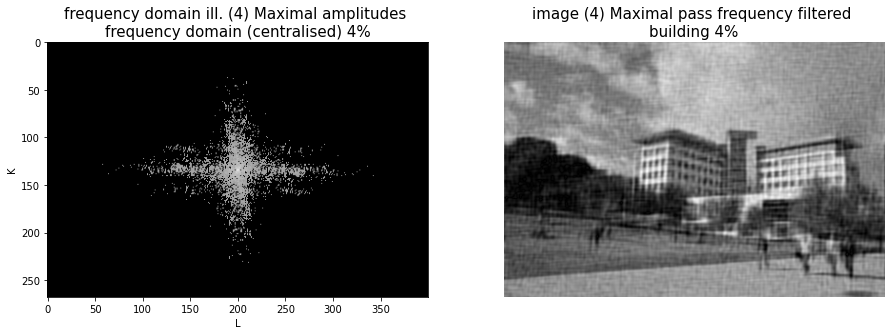

In [9]:
#part 1.e.
percentage = 4  # <-----------------------------------------change percentage here!
fMaxFreq, imgMaxFreq = max_freq_filtering(ftshift,percentage)
    
# display the filtered frequency domain result 
fMaxFreq_center = np.fft.ifftshift(fMaxFreq) 
fig = plt.figure(figsize=(15, 18))
ax = fig.add_subplot(1, 2, 1)  # create a subplot of certain size
ax.imshow(np.log(1 + np.abs(fMaxFreq_center)), cmap='gray')  
ax.set_title('frequency domain ill. (4) Maximal amplitudes \nfrequency domain (centralised) ' + str(percentage) + '%', fontsize=15)
ax.set_xlabel('L')
ax.set_ylabel('K')


# display reconstructed image we got from function 'max_freq_filtering'
ax = fig.add_subplot(1, 2, 2)  # create a subplot of certain size
ax.imshow(np.abs(imgMaxFreq), cmap='gray')
ax.set_title('image (4) Maximal pass frequency filtered \nbuilding ' + str(percentage) + '%', fontsize=15)
ax.set_axis_off()

Text(0, 0.5, 'MSE')

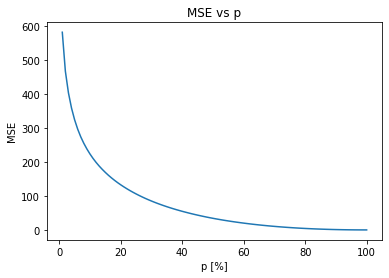

In [10]:
#part 1.f - Influence of the max frequencies precentege

def mse(img1, img2):
    h, w = img1.shape
    diff = abs(img1-img2) #distance betwwen two complex values
    err = np.sum(diff**2)
    mse = err/(h*w)
    return mse

mse_vector = np.zeros( 100 ) #mse results
p_vector = np.array ([i for i in range(1, 101)]) #percentage from 1-100
for p in range(1,101):
    [fMaxFreq , img_p] = max_freq_filtering(ftshift,p) #find p% filtered image 
    mse_vector[p-1] = mse(building_grayscale, img_p) #calculate mse for p%
plt.plot(p_vector,mse_vector)
plt.title('MSE vs p')
plt.xlabel('p [%]')
plt.ylabel('MSE')
